In [33]:
!pip install soundfile

In [0]:
# Import the machine learning libraries.
import numpy as np
import soundfile
import librosa
import glob
import os
from sklearn.model_selection import train_test_split

%matplotlib inline

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
# all emotions on RAVDESS dataset
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [0]:
# we allow only these emotions
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy"
}

In [0]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        if len(X.shape) == 2:
            print(X.shape)
            X = X[:,0]            
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [0]:
def load_data(test_size=0.2):
    X, y = [], []
    for file in glob.glob("/content/drive/My Drive/ML_Code/Speech Emotion Recognizer/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
        print(file)
        # get the base name of the audio file
        basename = os.path.basename(file)
        # get the emotion label
        emotion = int2emotion[basename.split("-")[2]]
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        # extract speech features
        features = extract_feature(file, mfcc=True, chroma=True, mel=True)
        # add to data
        X.append(features)
        y.append(emotion)
        #print(len(X), len(y), len(features), len(emotion))
    # split the data to training and testing and return it
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [40]:
# Load dataset.
%%time
X_train, X_test, y_train, y_test = load_data(test_size=0.25)

/content/drive/My Drive/ML_Code/Speech Emotion Recognizer/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav
/content/drive/My Drive/ML_Code/Speech Emotion Recognizer/Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-01-01-01.wav
/content/drive/My Drive/ML_Code/Speech Emotion Recognizer/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-02-01.wav
/content/drive/My Drive/ML_Code/Speech Emotion Recognizer/Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-02-01-01.wav
/content/drive/My Drive/ML_Code/Speech Emotion Recognizer/Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-01-02-01.wav
/content/drive/My Drive/ML_Code/Speech Emotion Recognizer/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-02-02-01.wav
/content/drive/My Drive/ML_Code/Speech Emotion Recognizer/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-02-01-01.wav
/content/drive/My Drive/ML_Code/Speech Emotion Recognizer/Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-01-01-01.wav
/content/drive/My Drive/ML_Code/Speech Emotion Recognize

In [41]:
print("[+] Number of training samples:", X_train.shape[0])
print("[+] Number of testing samples:", X_test.shape[0])
print("[+] Number of features:", X_train.shape[1])

[+] Number of training samples: 504
[+] Number of testing samples: 168
[+] Number of features: 180


In [0]:
# MLP Parameters
model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}
model = MLPClassifier(**model_params)

In [0]:
# Train the model.
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [44]:
# Print accuracy.
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 74.40%


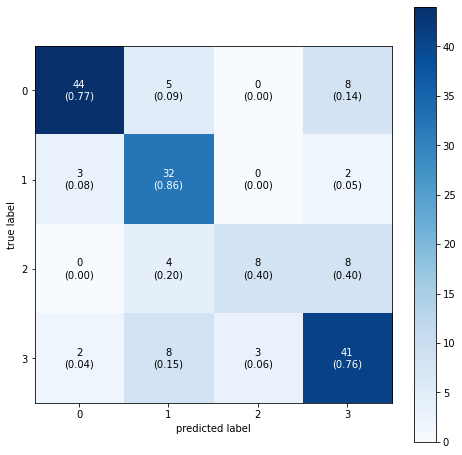

In [45]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Plot the confusion matrix.
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=cm,             
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      figsize=(8,8))
plt.show()

In [46]:
list(AVAILABLE_EMOTIONS)

['happy', 'sad', 'angry', 'neutral']

In [0]:
# Specify range of hyperparameters for MLP models.
params_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.05],
    'hidden_layer_sizes': [(100,50,10), (200,100,50), (500,250,50), (100,), (200,), (300,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant','adaptive'],
}

In [48]:
# Create a KFold object with 10 splits.
%%time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

folds = KFold(n_splits=3, shuffle=True, random_state=0)

# Set the parameters by cross-validation.
# Set up GridSearchCV() funcion.
mlp_model = GridSearchCV(MLPClassifier(), params_grid, scoring='accuracy', cv=folds)
mlp_model.fit(X_train, y_train)

CPU times: user 24min 22s, sys: 11min 12s, total: 35min 34s
Wall time: 18min 10s


In [49]:
# Print the accuracy score.
print('Best score for the training data:', mlp_model.best_score_, '\nusing', mlp_model.best_params_)

Best score for the training data: 0.7619047619047619 
using {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (500, 250, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
